In [1]:
import shutil
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, GlobalAveragePooling2D, Dropout
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import random

In [3]:
# Định nghĩa kích thước ảnh
img_width, img_height = 96, 96

# Tạo mô hình
def create_model():
    model = Sequential([
        Conv2D(32, (3, 3), input_shape=(img_height, img_width, 1)),
        MaxPooling2D((2, 2)),
        
        Conv2D(64, (3, 3)),
        MaxPooling2D((2, 2)),
        
        Conv2D(128, (3, 3)),
        MaxPooling2D((2, 2)),
        
        Conv2D(256, (3, 3)),
        MaxPooling2D((2, 2)),
        
        GlobalAveragePooling2D(),
        
        Dense(512, activation='relu'),
        Dropout(0.5),
        
        Dense(256, activation='relu'),
        Dropout(0.5),
        
        Dense(600, activation='softmax')  # Lớp đầu ra cho phân loại
    ])
    return model

# Tải trọng số mô hình
model = create_model()
model.load_weights('fingerprint_model_weights.weights.h5')

d:\Project\Th-c-t-p-t-t-nghi-p\venv\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━

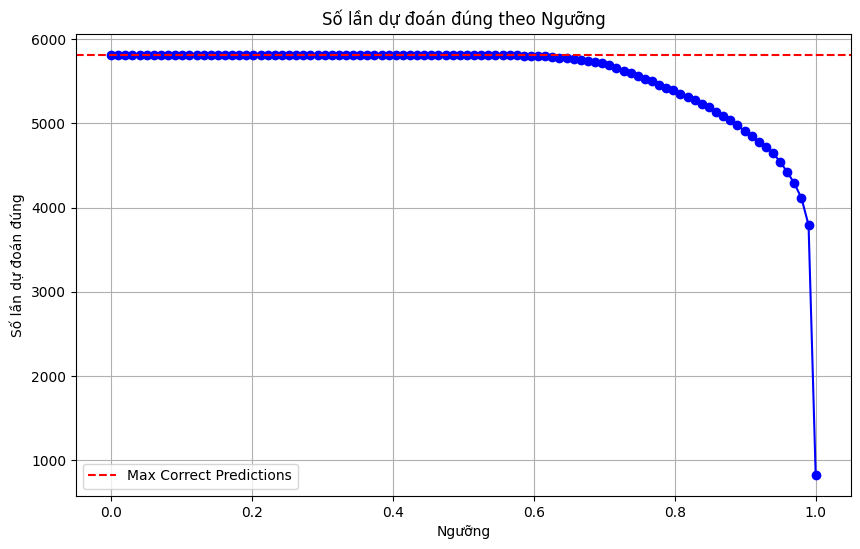

In [7]:
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity

# Hàm tiền xử lý ảnh
def preprocess_images(img_path):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (img_width, img_height))
    img = img.astype('float32') / 255.0
    img = np.expand_dims(img, axis=-1)  # Thêm chiều cho ảnh
    return img

# Hàm tìm nhãn tốt nhất cho từng ảnh
def verify_fingerprint(fingerprint_image_path, model, features, labels):
    # Tiền xử lý ảnh đầu vào
    input_image = preprocess_images(fingerprint_image_path)
    input_image = np.expand_dims(input_image, axis=0)

    # Trích xuất đặc trưng
    input_feature = model.predict(input_image).flatten()

    # Tính toán độ tương đồng cosine
    similarities = cosine_similarity([input_feature], features)

    # Tìm đặc trưng có độ tương đồng cao nhất
    best_match_index = np.argmax(similarities)
    best_match_label = labels[best_match_index]

    return best_match_label, similarities[0][best_match_index]

# Hàm tải và xử lý các ảnh chưa được huấn luyện
def load_untrained_images(imgnotrain_path, model, features, labels):
    similarities = []
    best_labels = []
    
    for file in os.listdir(imgnotrain_path):
        if file.endswith(".BMP"):  # Kiểm tra định dạng tệp tin
            img_path = os.path.join(imgnotrain_path, file)
            best_label, similarity = verify_fingerprint(img_path, model, features, labels)
            
            similarities.append(similarity)
            best_labels.append(best_label)

    return similarities, best_labels

def find_effective_thresholds(similarities, best_labels, actual_labels):
    if len(similarities) != len(best_labels) or len(best_labels) != len(actual_labels):
        raise ValueError("Các danh sách similarities, best_labels và actual_labels phải có cùng chiều dài.")

    thresholds = np.arange(0.5, 1.05, 0.05)  # Ngưỡng từ 0.5 đến 1 với bước nhảy 0.05
    correct_predictions_count = []

    # Đánh giá từng ngưỡng
    for threshold in thresholds:
        correct_predictions = 0
        
        # Đếm số lần dự đoán đúng
        for i in range(len(similarities)):
            if similarities[i] >= threshold and best_labels[i] == actual_labels[i]:
                correct_predictions += 1
        
        correct_predictions_count.append(correct_predictions)

    return thresholds, correct_predictions_count

# Đường dẫn tới folder imgnotrain
imgnotrain_path = "Data\\SOCOFing\\Test1\\imgnotrain"  # Cập nhật đường dẫn tới folder imgnotrain
features = np.load('fingerprint_features.npy')  # Tải đặc trưng đã lưu
labels = np.load('fingerprint_labels.npy')  # Tải nhãn đã lưu

# Tạo danh sách nhãn thực tế từ tên tệp (giả sử tên tệp có định dạng "0__image1.BMP")
actual_labels = []
for file in os.listdir(imgnotrain_path):
    if file.endswith(".BMP"):
        label = int(file.split("__")[0]) - 1  # Lấy nhãn từ tên tệp
        actual_labels.append(label)

# Tải và xử lý các hình ảnh chưa được huấn luyện
similarities, best_labels = load_untrained_images(imgnotrain_path, model, features, labels)
if len(similarities) != len(best_labels) or len(best_labels) != len(actual_labels):
    print("Lỗi: Các danh sách không có cùng chiều dài.")
else:
    thresholds, correct_predictions_count = find_effective_thresholds(similarities, best_labels, actual_labels)

    # In ra các ngưỡng với số lần đúng nhiều nhất
    max_correct_predictions = max(correct_predictions_count)  # Số lần đúng tối đa
    best_thresholds = [thresholds[i] for i, count in enumerate(correct_predictions_count) if count == max_correct_predictions]

    print(f'Ngưỡng với số lần dự đoán đúng nhiều nhất: {best_thresholds} với số lần đúng: {max_correct_predictions}')

    # Vẽ biểu đồ số lần dự đoán đúng cho từng ngưỡng
    plt.figure(figsize=(10, 6))
    plt.plot(thresholds, correct_predictions_count, marker='o', linestyle='-', color='b')
    plt.title('Số lần dự đoán đúng theo Ngưỡng')
    plt.xlabel('Ngưỡng')
    plt.ylabel('Số lần dự đoán đúng')
    plt.xticks(np.arange(0.5, 1.05, 0.05))  # Đặt các nhãn trục x với bước nhảy 0.05
    plt.grid(True)
    plt.axhline(y=max_correct_predictions, color='r', linestyle='--', label='Max Correct Predictions')
    plt.legend()
    plt.show()

In [ ]:
plt.title('Số lần dự đoán đúng theo Ngưỡng')
plt.xlabel('Ngưỡng')
plt.ylabel('Số lần dự đoán đúng')
plt.grid(True)
plt.axhline(y=max_correct_predictions, color='r', linestyle='--', label='Max Correct Predictions')
plt.legend()
plt.show()